In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,  LSTM,  Dropout
%matplotlib inline
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from plot_keras_history import plot_history

Using TensorFlow backend.
C:\home\anaconda\envs\TF\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
path = os.getcwd()
print(path)

C:\home\program


In [3]:
os.chdir('../')

In [4]:
df = pd.read_csv('program/stock2.csv', encoding="shift_jis")
df['day'] = pd.to_datetime(df['day'], format='%Y/%m/%d')
timeSeries = df.loc[:, ["day","end"]]
timeSeries.index = timeSeries.day
ts = timeSeries.drop("day",axis=1)

In [5]:
df.set_index('day')
dateTimeIndex = pd.DatetimeIndex(df['day'])
df.index = dateTimeIndex
df[df.index.duplicated(keep=False)]

,day,start,hight,low,end
day,,,,,
2019-04-01,2019-04-01,3340.0,3390.0,3330.0,3380.0
2019-04-01,2019-04-01,3340.0,3390.0,3330.0,3380.0


In [6]:
print(ts.index.get_loc("2019-04-01"))

slice(469, 471, None)


In [7]:
df = df.drop(df.index[[469]])
df = df.resample('D').interpolate()
df['day']=df.index

In [8]:
L = len(df)
Y = df.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [9]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [10]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [11]:
scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [12]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [13]:
len(X)

1179

In [14]:
# train, testデータを定義
X_train = X[:500, :, :]
X_test = X[500:, :, :]
Y_train = Y[:500, :]
Y_test = Y[500:, :]

In [15]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 0s - loss: 0.3708 - mean_absolute_error: 0.6054
Epoch 2/50
 - 0s - loss: 0.2434 - mean_absolute_error: 0.4903
Epoch 3/50
 - 0s - loss: 0.1536 - mean_absolute_error: 0.3886
Epoch 4/50
 - 0s - loss: 0.0847 - mean_absolute_error: 0.2876
Epoch 5/50
 - 0s - loss: 0.0374 - mean_absolute_error: 0.1888
Epoch 6/50
 - 0s - loss: 0.0111 - mean_absolute_error: 0.0981
Epoch 7/50
 - 0s - loss: 0.0019 - mean_absolute_error: 0.0347
Epoch 8/50
 - 0s - loss: 6.5881e-04 - mean_absolute_error: 0.0195
Epoch 9/50
 - 0s - loss: 6.3672e-04 - mean_absolute_error: 0.0194
Epoch 10/50
 - 0s - loss: 6.2498e-04 - mean_absolute_error: 0.0192
Epoch 11/50
 - 0s - loss: 6.2861e-04 - mean_absolute_error: 0.0194
Epoch 12/50
 - 0s - loss: 5.8225e-04 - mean_absolute_error: 0.0188
Epoch 13/50
 - 0s - loss: 5.8518e-04 - mean_absolute_error: 0.0186
Epoch 14/50
 - 0s - loss: 5.4409e-04 - mean_absolute_error: 0.0181
Epoch 15/50
 - 0s - loss: 5.4204e-04 - mean_absolute_error: 0.0178
Epoch 16/50
 - 0s - loss: 5.1302

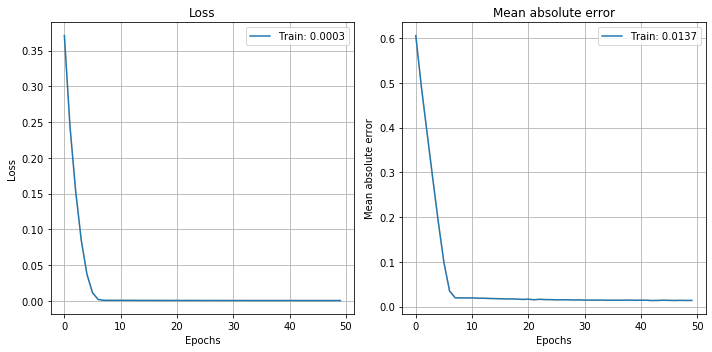

In [16]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
Predict = model.predict(X_test)

In [17]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(df.iloc[3:503,0])

In [18]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(df.iloc[503:,0])

In [19]:
Predict = scaler1.inverse_transform(Predict)
Predict = pd.DataFrame(Predict)
Predict.index=pd.to_datetime(df.iloc[503:,0])

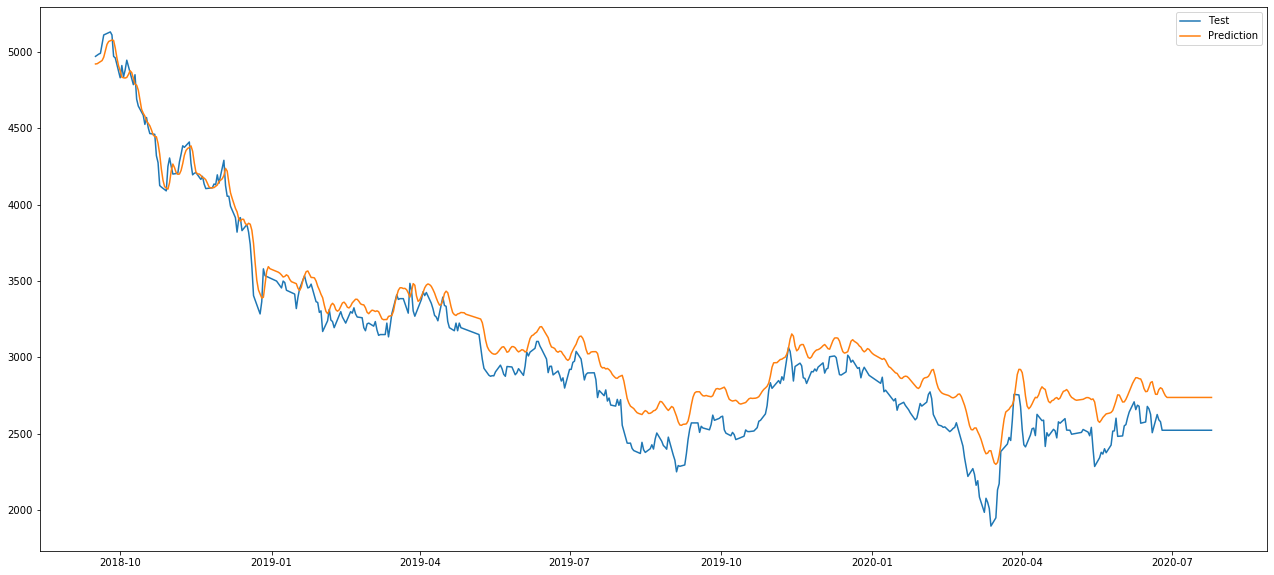

In [20]:
plt.figure(figsize=(22,10))
plt.plot(Y_test, label = 'Test')
plt.plot(Predict, label = 'Prediction')
plt.legend(loc='best')
plt.show()

In [21]:
ts[ts.index.duplicated(keep=False)]

,end
day,
2019-04-01,3380.0
2019-04-01,3380.0


In [22]:
print(ts.index.get_loc("2019-04-01"))

slice(469, 471, None)


In [23]:
ts = ts.drop(ts.index[[469]])
ts = ts.resample('D').interpolate()

In [24]:
# train, testデータを定義
X_train = X[:200, :, :]
X_test = X[201:400, :, :]
Y_train = Y[:200, :]
Y_test = Y[201:400, :]

Epoch 1/50
 - 0s - loss: 1.8681e-04 - mean_absolute_error: 0.0101
Epoch 2/50
 - 0s - loss: 1.8404e-04 - mean_absolute_error: 0.0102
Epoch 3/50
 - 0s - loss: 1.8198e-04 - mean_absolute_error: 0.0100
Epoch 4/50
 - 0s - loss: 1.9473e-04 - mean_absolute_error: 0.0105
Epoch 5/50
 - 0s - loss: 2.0749e-04 - mean_absolute_error: 0.0109
Epoch 6/50
 - 0s - loss: 1.7638e-04 - mean_absolute_error: 0.0102
Epoch 7/50
 - 0s - loss: 2.0045e-04 - mean_absolute_error: 0.0107
Epoch 8/50
 - 0s - loss: 1.7476e-04 - mean_absolute_error: 0.0093
Epoch 9/50
 - 0s - loss: 2.0013e-04 - mean_absolute_error: 0.0101
Epoch 10/50
 - 0s - loss: 1.7440e-04 - mean_absolute_error: 0.0098
Epoch 11/50
 - 0s - loss: 1.7799e-04 - mean_absolute_error: 0.0098
Epoch 12/50
 - 0s - loss: 2.0523e-04 - mean_absolute_error: 0.0107
Epoch 13/50
 - 0s - loss: 1.6649e-04 - mean_absolute_error: 0.0093
Epoch 14/50
 - 0s - loss: 1.8036e-04 - mean_absolute_error: 0.0098
Epoch 15/50
 - 0s - loss: 1.8776e-04 - mean_absolute_error: 0.0101
Epoc

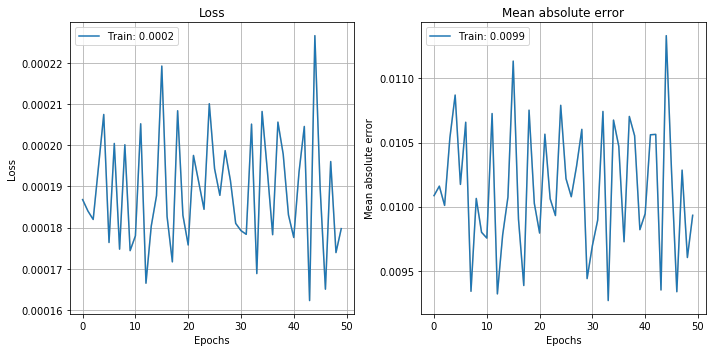

In [25]:
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
Predict2 = model.predict(X_test)

In [26]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(df.iloc[3:203,0])

In [27]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(df.iloc[204:403,0])

In [28]:
Predict2 = scaler1.inverse_transform(Predict2)
Predict2 = pd.DataFrame(Predict2)
Predict2.index=pd.to_datetime(df.iloc[204:403,0])

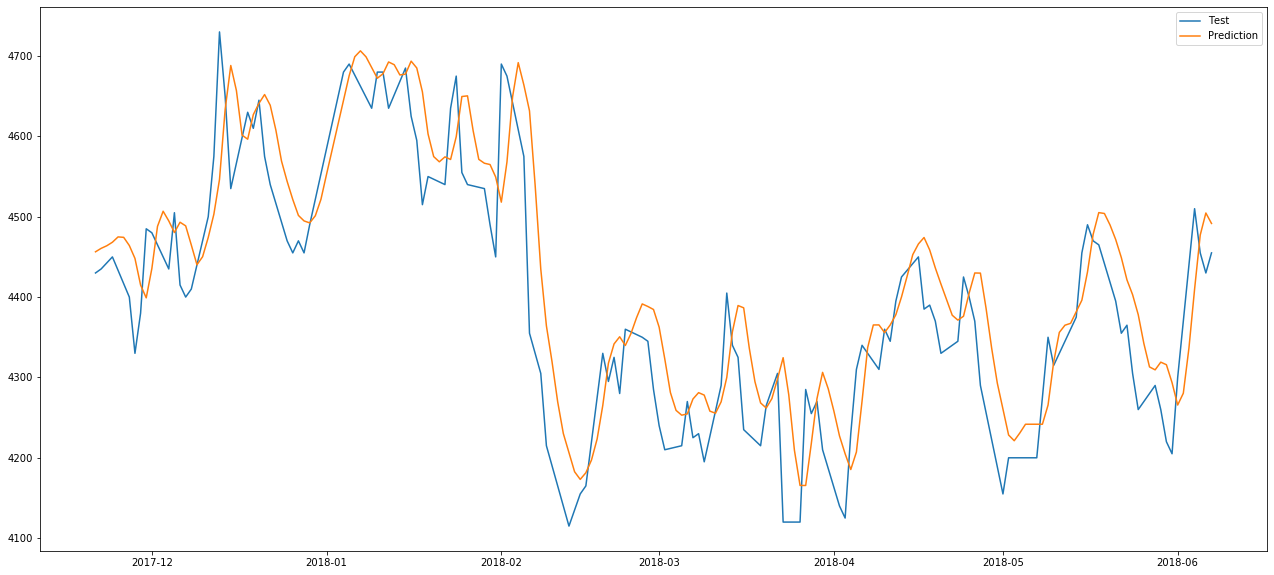

In [29]:
plt.figure(figsize=(22,10))
plt.plot(Y_test, label = 'Test')
plt.plot(Predict2, label = 'Prediction')
plt.legend(loc='best')
plt.show()

In [30]:
# train, testデータを定義
X_train = X[201:400, :, :]
X_test = X[401:600, :, :]
Y_train = Y[201:400, :]
Y_test = Y[401:600, :]

Epoch 1/50
 - 0s - loss: 4.7183e-04 - mean_absolute_error: 0.0164
Epoch 2/50
 - 0s - loss: 4.5850e-04 - mean_absolute_error: 0.0165
Epoch 3/50
 - 0s - loss: 4.3829e-04 - mean_absolute_error: 0.0160
Epoch 4/50
 - 0s - loss: 4.9071e-04 - mean_absolute_error: 0.0169
Epoch 5/50
 - 0s - loss: 4.4453e-04 - mean_absolute_error: 0.0160
Epoch 6/50
 - 0s - loss: 4.2709e-04 - mean_absolute_error: 0.0156
Epoch 7/50
 - 0s - loss: 4.4007e-04 - mean_absolute_error: 0.0156
Epoch 8/50
 - 0s - loss: 4.6213e-04 - mean_absolute_error: 0.0167
Epoch 9/50
 - 0s - loss: 4.4558e-04 - mean_absolute_error: 0.0162
Epoch 10/50
 - 0s - loss: 4.2548e-04 - mean_absolute_error: 0.0159
Epoch 11/50
 - 0s - loss: 4.5920e-04 - mean_absolute_error: 0.0163
Epoch 12/50
 - 0s - loss: 4.6145e-04 - mean_absolute_error: 0.0162
Epoch 13/50
 - 0s - loss: 4.5071e-04 - mean_absolute_error: 0.0166
Epoch 14/50
 - 0s - loss: 4.1234e-04 - mean_absolute_error: 0.0155
Epoch 15/50
 - 0s - loss: 4.9201e-04 - mean_absolute_error: 0.0171
Epoc

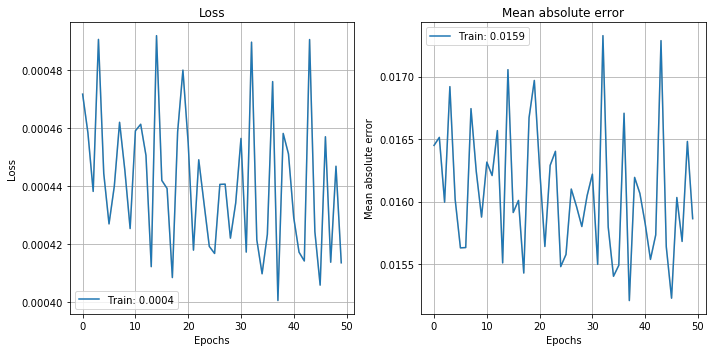

In [31]:
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
Predict3 = model.predict(X_test)

In [32]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(df.iloc[204:403,0])

In [33]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(df.iloc[404:603,0])

In [34]:
Predict3 = scaler1.inverse_transform(Predict3)
Predict3 = pd.DataFrame(Predict3)
Predict3.index=pd.to_datetime(df.iloc[404:603,0])

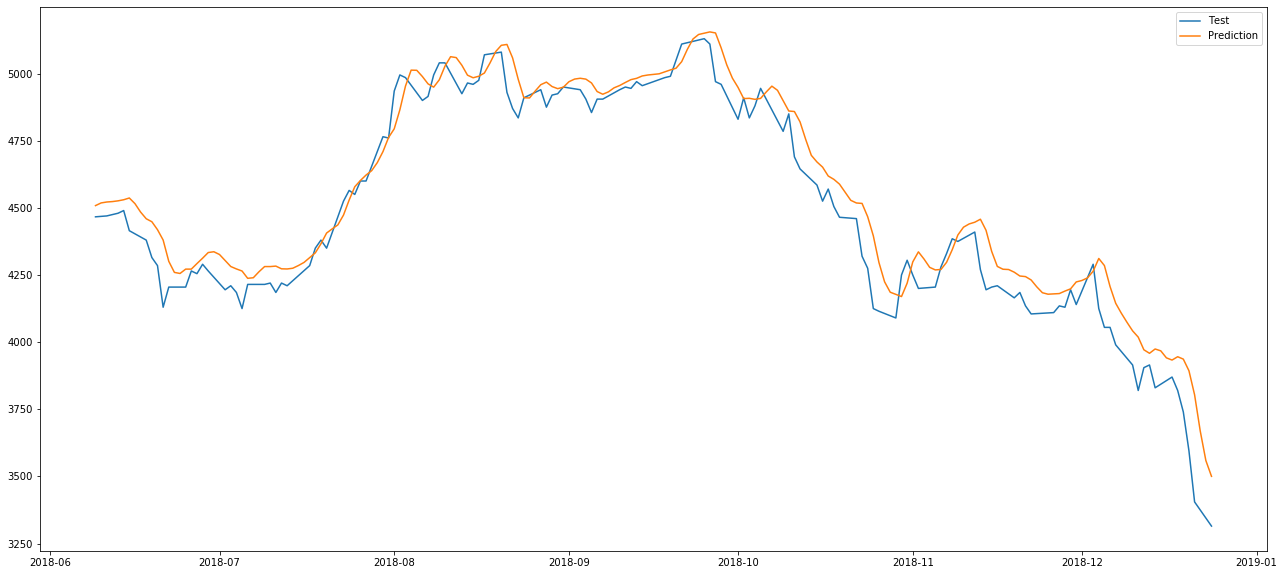

In [35]:
plt.figure(figsize=(22,10))
plt.plot(Y_test, label = 'Test')
plt.plot(Predict3, label = 'Prediction')
plt.legend(loc='best')
plt.show()

In [36]:
# train, testデータを定義
X_train = X[401:600, :, :]
X_test = X[601:, :, :]
Y_train = Y[401:600, :]
Y_test = Y[601:, :]

Epoch 1/50
 - 0s - loss: 7.1690e-04 - mean_absolute_error: 0.0198
Epoch 2/50
 - 0s - loss: 6.1952e-04 - mean_absolute_error: 0.0191
Epoch 3/50
 - 0s - loss: 6.1507e-04 - mean_absolute_error: 0.0186
Epoch 4/50
 - 0s - loss: 6.0738e-04 - mean_absolute_error: 0.0189
Epoch 5/50
 - 0s - loss: 5.5874e-04 - mean_absolute_error: 0.0178
Epoch 6/50
 - 0s - loss: 6.0212e-04 - mean_absolute_error: 0.0194
Epoch 7/50
 - 0s - loss: 5.8144e-04 - mean_absolute_error: 0.0182
Epoch 8/50
 - 0s - loss: 5.6914e-04 - mean_absolute_error: 0.0177
Epoch 9/50
 - 0s - loss: 6.5083e-04 - mean_absolute_error: 0.0196
Epoch 10/50
 - 0s - loss: 5.4239e-04 - mean_absolute_error: 0.0180
Epoch 11/50
 - 0s - loss: 5.2833e-04 - mean_absolute_error: 0.0172
Epoch 12/50
 - 0s - loss: 5.6685e-04 - mean_absolute_error: 0.0179
Epoch 13/50
 - 0s - loss: 5.7295e-04 - mean_absolute_error: 0.0184
Epoch 14/50
 - 0s - loss: 5.4257e-04 - mean_absolute_error: 0.0175
Epoch 15/50
 - 0s - loss: 5.2993e-04 - mean_absolute_error: 0.0169
Epoc

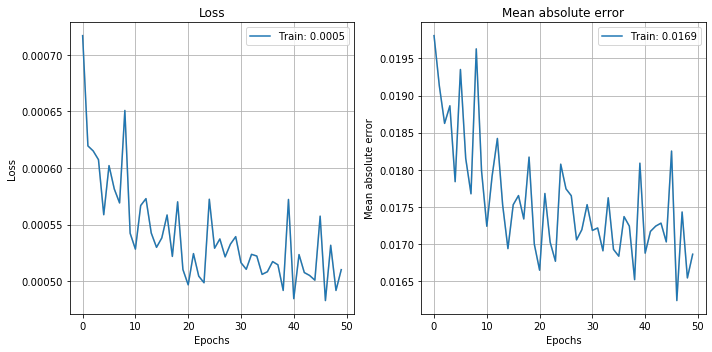

In [37]:
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
Predict4 = model.predict(X_test)

In [38]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(df.iloc[404:603,0])

In [39]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(df.iloc[604:,0])

In [40]:
Predict4 = scaler1.inverse_transform(Predict4)
Predict4 = pd.DataFrame(Predict4)
Predict4.index=pd.to_datetime(df.iloc[604:,0])

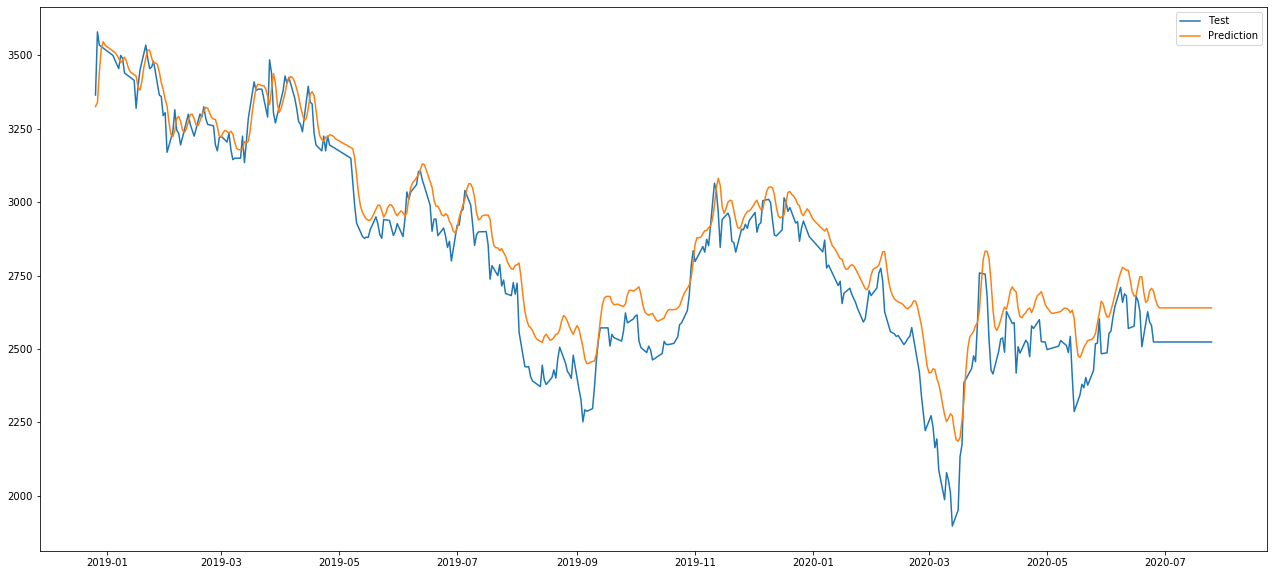

In [41]:
plt.figure(figsize=(22,10))
plt.plot(Y_test, label = 'Test')
plt.plot(Predict4, label = 'Prediction')
plt.legend(loc='best')
plt.show()

In [42]:
conect_Predict = pd.concat([Predict2, Predict3, Predict4])

In [43]:
conect_Predict

,0
day,
2017-11-21,4456.354980
2017-11-22,4460.636230
2017-11-23,4463.856445
2017-11-24,4468.256836
2017-11-25,4474.870117
...,...
2020-07-21,2640.199219
2020-07-22,2640.199219
2020-07-23,2640.199219


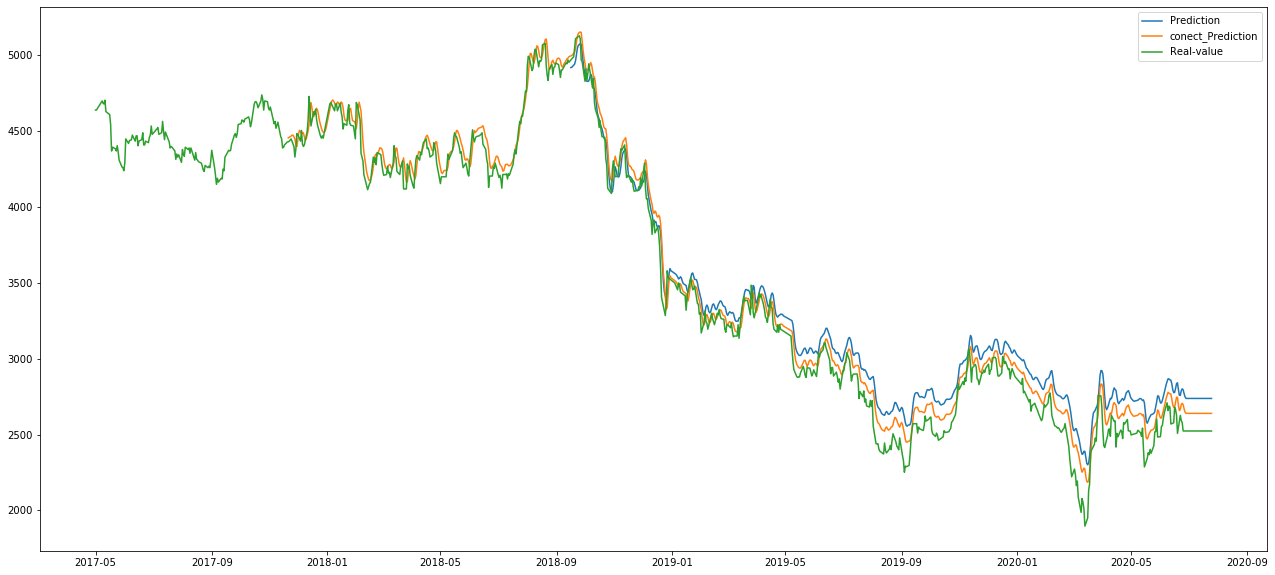

In [44]:
plt.figure(figsize=(22,10))
plt.plot(Predict, label = 'Prediction')
plt.plot(conect_Predict, label = 'conect_Prediction')
plt.plot(df['end'], label = 'Real-value')
plt.legend(loc='best')
plt.show()

# 2011

In [60]:
df11 = pd.read_csv('program/stock2011.csv', encoding="shift_jis")
df11['day'] = pd.to_datetime(df11['day'], format='%Y/%m/%d')
timeSeries = df11.loc[:, ["day","end"]]
timeSeries.index = timeSeries.day
ts11 = timeSeries.drop("day",axis=1)

In [61]:
df11.set_index('day')
dateTimeIndex = pd.DatetimeIndex(df11['day'])
df11.index = dateTimeIndex
df11[df11.index.duplicated(keep=False)]

,day,start,hight,low,end
day,,,,,


In [62]:
df11 = df11.resample('D').interpolate()
df11['day']=df11.index

In [63]:
L = len(df11)
Y11 = df11.iloc[:, 4]  # 終値の列のみ抽出する。
Y11 = np.array(Y11)  # numpy配列に変換する。
Y11 = Y11.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [64]:
X1 = Y11[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y11[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y11[2:L-1, :]  # 予測対象日の前日データ
Y11 = Y11[3:L, :]  # 予測対象日のデータ
X11 = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [65]:
scaler.fit(X11)  # スケーリングに使用する最小／最大値を計算する。
X11 = scaler.transform(X11)  # Xをを0～1の範囲にスケーリングする。

In [66]:
scaler1.fit(Y11)  # スケーリングに使用する最小／最大値を計算する。
Y11 = scaler1.transform(Y11)  # Yをを0～1の範囲にスケーリングする。

In [67]:
X11 = np.reshape(X11, (X11.shape[0], 1, X11.shape[1]))  # 3次元配列に変換する。

In [68]:
# train, testデータを定義
X_train11 = X11[:700, :, :]
X_test11 = X11[700:, :, :]
Y_train11 = Y11[:700, :]
Y_test11 = Y11[700:, :]

In [69]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 0s - loss: 0.0977 - mean_absolute_error: 0.2690
Epoch 2/50
 - 0s - loss: 0.0477 - mean_absolute_error: 0.1729
Epoch 3/50
 - 0s - loss: 0.0200 - mean_absolute_error: 0.1013
Epoch 4/50
 - 0s - loss: 0.0084 - mean_absolute_error: 0.0670
Epoch 5/50
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0577
Epoch 6/50
 - 0s - loss: 0.0029 - mean_absolute_error: 0.0436
Epoch 7/50
 - 0s - loss: 0.0014 - mean_absolute_error: 0.0288
Epoch 8/50
 - 0s - loss: 7.1336e-04 - mean_absolute_error: 0.0183
Epoch 9/50
 - 0s - loss: 5.7524e-04 - mean_absolute_error: 0.0156
Epoch 10/50
 - 0s - loss: 5.6041e-04 - mean_absolute_error: 0.0150
Epoch 11/50
 - 0s - loss: 5.5840e-04 - mean_absolute_error: 0.0151
Epoch 12/50
 - 0s - loss: 5.5763e-04 - mean_absolute_error: 0.0151
Epoch 13/50
 - 0s - loss: 5.5554e-04 - mean_absolute_error: 0.0150
Epoch 14/50
 - 0s - loss: 5.5060e-04 - mean_absolute_error: 0.0150
Epoch 15/50
 - 0s - loss: 5.4662e-04 - mean_absolute_error: 0.0148
Epoch 16/50
 - 0s - loss: 5.4532

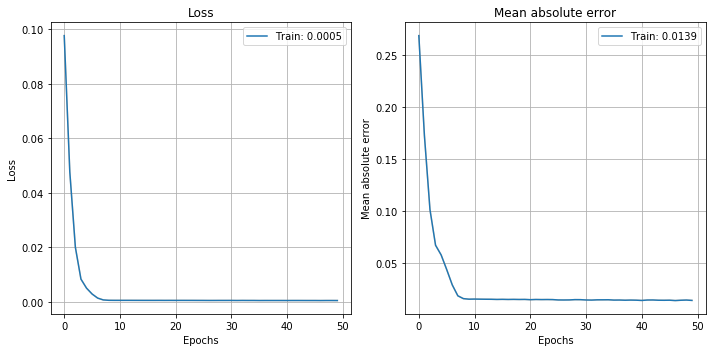

In [70]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train11, Y_train11, epochs=50, verbose=2).history
plot_history(history)
Predict11 = model.predict(X_test11)

In [71]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train11 = scaler1.inverse_transform(Y_train11)
Y_train11 = pd.DataFrame(Y_train11)
Y_train11.index = pd.to_datetime(df11.iloc[3:703,0])

In [72]:
Y_test11 = scaler1.inverse_transform(Y_test11)
Y_test11 = pd.DataFrame(Y_test11)
Y_test11.index = pd.to_datetime(df11.iloc[703:,0])

In [73]:
Predict11 = scaler1.inverse_transform(Predict11)
Predict11 = pd.DataFrame(Predict11)
Predict11.index=pd.to_datetime(df11.iloc[703:,0])

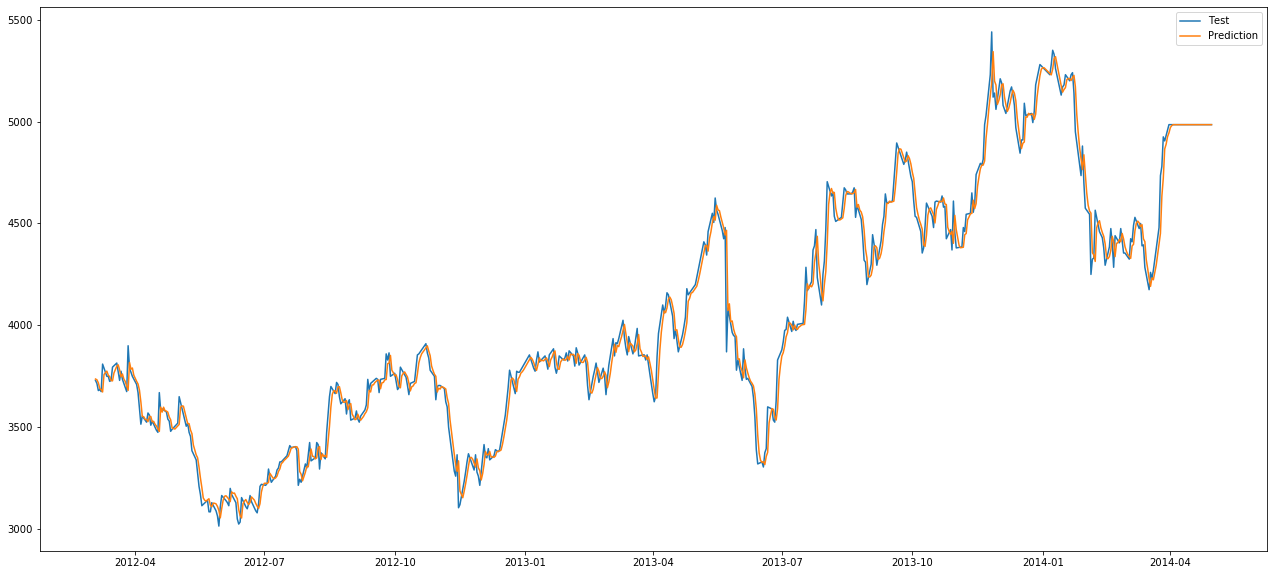

In [74]:
plt.figure(figsize=(22,10))
plt.plot(Y_test11, label = 'Test')
plt.plot(Predict11, label = 'Prediction')
plt.legend(loc='best')
plt.show()

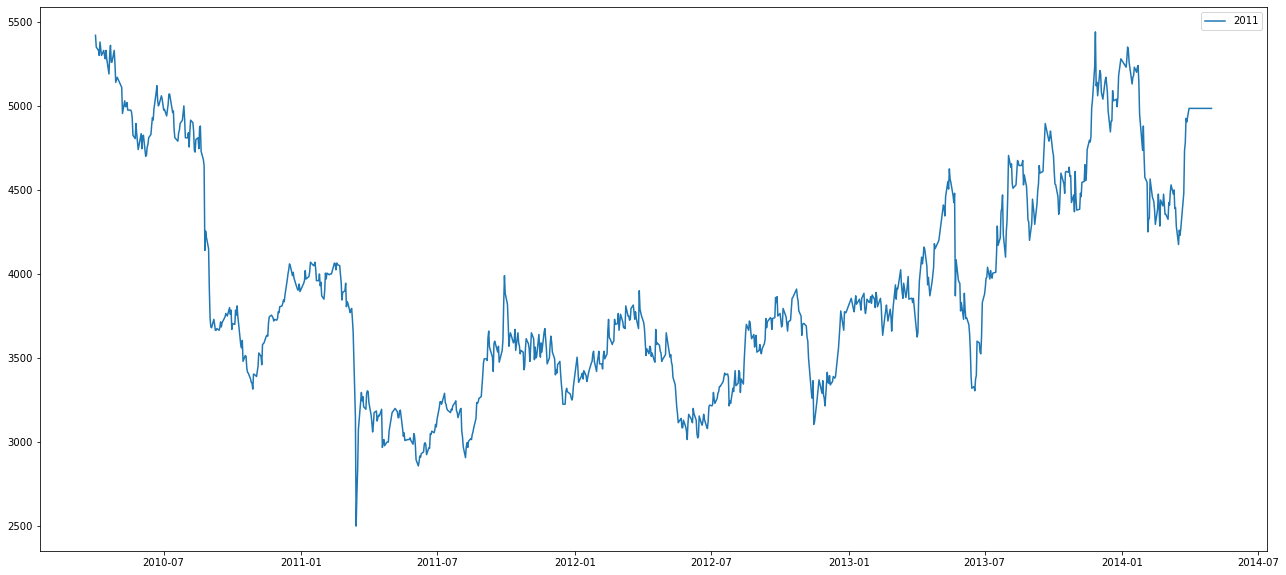

In [75]:
plt.figure(figsize=(22,10))
plt.plot(df11['end'], label = '2011')
plt.legend(loc='best')
plt.show()

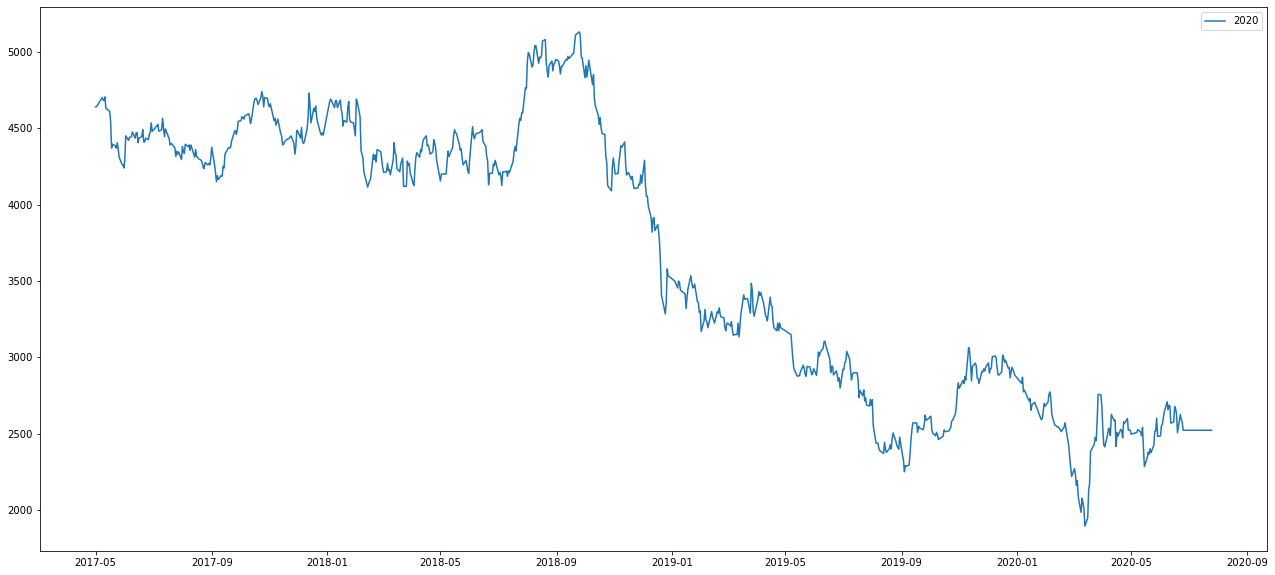

In [76]:
plt.figure(figsize=(22,10))
plt.plot(df['end'], label = '2020')
plt.legend(loc='best')
plt.show()

In [77]:
def ema(milktea, period):
    ema = np.zeros(len(milktea))
    ema[:] = np.nan # NaN で一旦初期化
    ema[period-1] = milktea[:period].mean() # 最初だけ単純移動平均で算出
    
    for day in range(period, len(milktea)):
        ema[day] = ema[day-1] + (milktea[day] - ema[day-1]) / (period + 1) * 2
    
    return ema

In [78]:
df11["指数移動平均(30)"]=ema(df11['end'], 30).round(1)
df["指数移動平均(30)"]=ema(df['end'], 30).round(1)

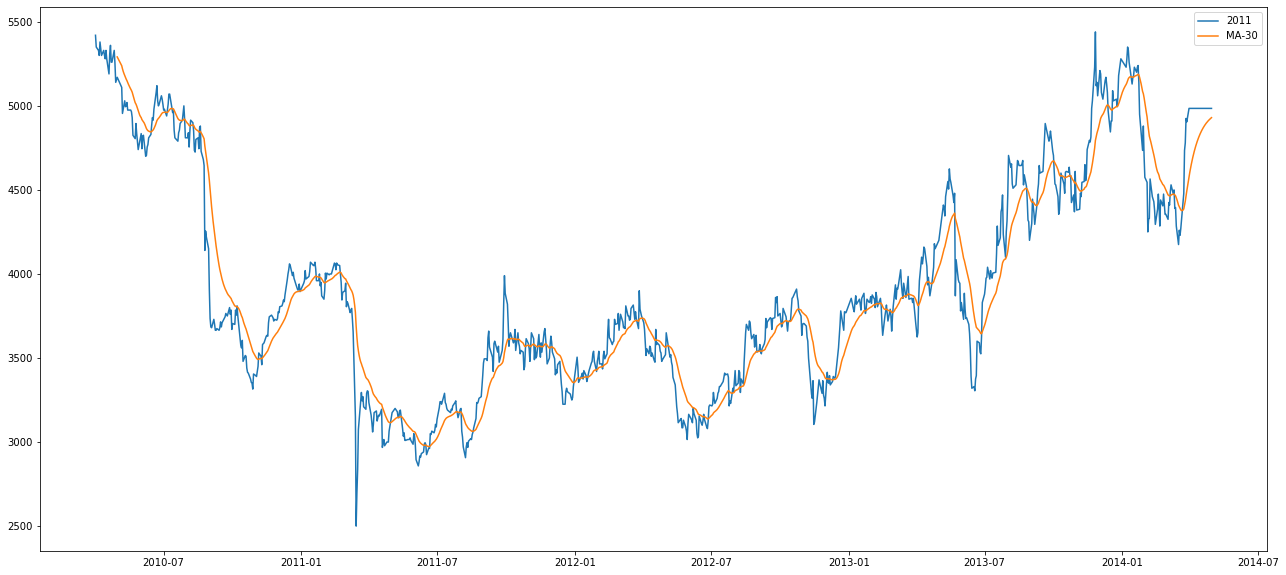

In [79]:
plt.figure(figsize=(22,10))
plt.plot(df11['end'], label = '2011')
plt.plot(df11["指数移動平均(30)"], label = 'MA-30')
plt.legend(loc='best')
plt.show()

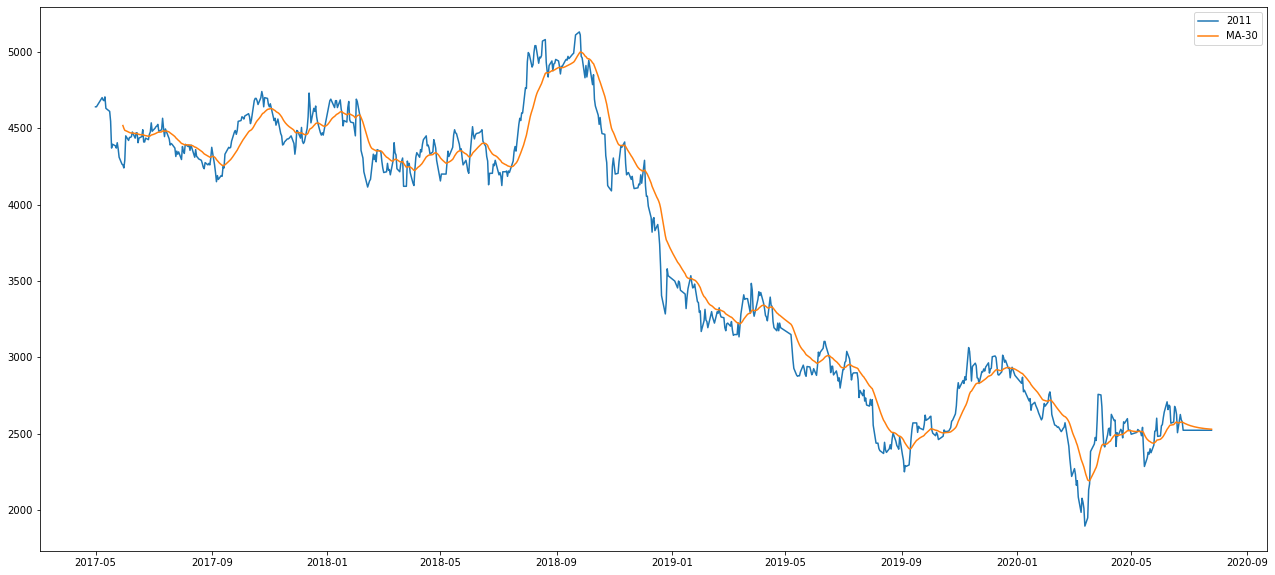

In [80]:
plt.figure(figsize=(22,10))
plt.plot(df['end'], label = '2011')
plt.plot(df["指数移動平均(30)"], label = 'MA-30')
plt.legend(loc='best')
plt.show()